In [199]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [200]:
df_train = pd.read_csv('data/train.csv', sep=",")
df_test = pd.read_csv('data/test.csv', sep=",")

# Feature Engineering

Show which columns contain NaN

In [201]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [202]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [203]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### OneHotEncoder for Sex

In [204]:
from sklearn.preprocessing import OneHotEncoder
# ohc_sex = OneHotEncoder(sparse=False, dtype=int)
# ohc_sex.fit(df[["Sex"]])
# t = ohc_sex.transform(df[["Sex"]])
# sex_matrix = pd.DataFrame(t, columns=ohc_sex.get_feature_names())
# df = pd.concat([df, sex_matrix], axis=1).drop(["Sex"], axis=1)

In [205]:
df2 = pd.get_dummies(df_train, prefix=['Sex'], columns = ['Sex'], drop_first=True)
df_train = df2
df2 = pd.get_dummies(df_test, prefix=['Sex'], columns = ['Sex'], drop_first=True)
df_test = df2

### Names aka Social Rank

In [206]:
df_train['rank'] = df_train['Name'].str.split('([A-Za-z]+)(\.)', expand=True)[1]
df_train["rank"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [207]:
for df in (df_train, df_test):
    df['rank'] = df['Name'].str.split('([A-Za-z]+)(\.)', expand=True)[1]
    titles = df["rank"].unique().tolist()
    # rank = [0,0,0,4,6,2,2,1,1,4,6,6,0,4,4,6,6]
    # rank = [3,2,1,9,10,4,5,2,2,11,6,8,1,12,13,7,14]
    rank = [0,0,0,2,2,1,1,0,0,2,2,0,0,2,2,2,2]
    dic = {}
    for title, rank in zip(titles, rank):
        dic[title] = rank
    df["rank"].replace(dic, inplace=True)
    df["rank"] = df["rank"] + (df["Sex_male"]+0.5)
df_train = df_train.drop(columns=["Name", "Sex_male"])
df_test = df_test.drop(columns=["Name", "Sex_male"])

### Family Size

In [208]:
for df in (df_train, df_test):
    df["fam_size"] = df["SibSp"] + df["Parch"]

### Fare

In [209]:
for df in (df_train, df_test):
    df["Fare"].fillna(0, inplace=True)
    df["fare_pp"] = df["Fare"] / (df["fam_size"] + 1)

In [210]:
for df in (df_train, df_test):
        for row, value in df.loc[df["fare_pp"] == 0]["Pclass"].iteritems():
            df.loc[row, "fare_pp"] = df.loc[df["Pclass"] == value]["fare_pp"].mean()

In [211]:
import numpy as np
for df in (df_train, df_test):
    df["fare_pp"] = np.log(df["fare_pp"] + 1)
df_train = df_train.drop(columns=["Fare"])
df_test = df_test.drop(columns=["Fare"])

### Pipeline of OHE and Imputation for Embarked

In [212]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
impute_and_encode = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False))

In [213]:
impute_and_encode.fit(df_train[["Embarked"]])
t = impute_and_encode.transform(df_train[["Embarked"]])
embarked_matrix = pd.DataFrame(t, columns=impute_and_encode[1].get_feature_names())
df_train = pd.concat([df_train, embarked_matrix], axis=1).drop(["Embarked"], axis=1)

In [214]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Age            177
SibSp            0
Parch            0
Ticket           0
Cabin          687
rank             0
fam_size         0
fare_pp          0
x0_C             0
x0_Q             0
x0_S             0
dtype: int64

In [215]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import statistics

model = LogisticRegression(max_iter=1000)
accuracy = cross_val_score(model, df_train[["Pclass", "fare_pp", "rank"]], df_train["x0_Q"], cv=15, scoring='accuracy')
print("cross-validation scores", accuracy)
print("median of cross-validation scores", statistics.median(accuracy))

cross-validation scores [0.91666667 0.91666667 0.91666667 0.91666667 0.9        0.9
 0.91525424 0.91525424 0.91525424 0.91525424 0.91525424 0.91525424
 0.91525424 0.91525424 0.91525424]
median of cross-validation scores 0.9152542372881356


In [216]:
df_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Cabin,rank,fam_size,fare_pp,x0_C,x0_Q,x0_S
0,1,0,3,22.0,1,0,A/5 21171,NaN,1.5,1,1.531476,0.0,0.0,1.0
1,2,1,1,38.0,1,0,PC 17599,C85,0.5,1,3.601186,1.0,0.0,0.0
2,3,1,3,26.0,0,0,STON/O2. 3101282,NaN,0.5,0,2.188856,0.0,0.0,1.0
3,4,1,1,35.0,1,0,113803,C123,0.5,1,3.316003,0.0,0.0,1.0
4,5,0,3,35.0,0,0,373450,NaN,1.5,0,2.202765,0.0,0.0,1.0


### Cabin

In [217]:
for df in (df_train, df_test):
    df["Cabin"] = df["Cabin"].fillna("Z")
    result = df["Cabin"].astype(str).str[0]
    df["deck"] = result.replace({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 1, "Z": 3.5})
    df["cabin_number"] = df["Cabin"].str.split('([A-Za-z]+)(\d+)', expand=True)[2]

In [218]:
df_train["cabin_number"].unique()

array([None, '85', '123', '46', '6', '103', '56', '23', '78', '33', '30',
       '52', '28', '83', '73', '31', '5', '10', '26', '110', '58', '101',
       '69', '47', '86', '2', '19', '7', '49', '4', '32', '80', '36',
       '15', '93', '35', '87', '77', '67', '94', '125', '99', '118', '22',
       '106', '65', '54', '57', '34', '18', '124', '91', '40', '128',
       '37', '50', '82', '96', '44', '104', '111', '92', '38', '21', '12',
       '63', '14', '20', '79', '25', '95', '39', '70', '16', '68', '41',
       '9', '48', '126', '71', '51', '62', '24', '90', '45', '8', '121',
       '11', '3', '17', '102', '42', '148'], dtype=object)

In [219]:
for df in (df_train, df_test):
    for row, value in df.loc[df["cabin_number"].isna()]["Pclass"].iteritems():
        df.loc[row, "cabin_number"] = df[df["Pclass"] == df.loc[row, "Pclass"]]["cabin_number"].median()
#    df["cabin_number"] = df["cabin_number"].fillna(df["cabin_number"].median()).astype(int)
    print(df["cabin_number"])

0      50.5
1        85
2      50.5
3       123
4      50.5
       ... 
886      33
887      42
888    50.5
889     148
890    50.5
Name: cabin_number, Length: 891, dtype: object
0      51.5
1      51.5
2         4
3      51.5
4      51.5
       ... 
413    51.5
414     105
415    51.5
416    51.5
417    51.5
Name: cabin_number, Length: 418, dtype: object


In [220]:
df_train["cabin_number"].unique()

array([50.5, '85', '123', '46', 33.0, '6', '103', '56', '23', 44.0, '78',
       '33', '30', '52', '28', '83', '73', '31', '5', '10', '26', '110',
       '58', '101', '69', '47', '86', '2', '19', '7', '49', '4', '32',
       '80', '36', '15', '93', '35', '87', '77', '67', '94', '125', '99',
       '118', '22', '106', '65', '54', '57', '34', '18', '124', '91',
       '40', '128', '37', '50', '82', '96', '44', '104', '111', '92',
       '38', '21', '12', '63', '14', '20', '79', '25', '95', '39', '70',
       '16', '68', '41', '9', '48', '126', '71', '51', '62', '24', '90',
       '45', '8', '121', '11', '3', '17', '102', '42', '148'],
      dtype=object)

In [221]:
df_train["cabin_number"]

0      50.5
1        85
2      50.5
3       123
4      50.5
       ... 
886      33
887      42
888    50.5
889     148
890    50.5
Name: cabin_number, Length: 891, dtype: object

### Imputation and Binning for Age

In [222]:
from sklearn.impute import SimpleImputer
# imp_age = SimpleImputer(strategy="median")
# imp_age.fit(df[["Age"]])
# t = imp_age.transform(df[["Age"]])
# df["Age"] = t

In [223]:
# df["Age"] = df["Age"].fillna(df["Age"].median()).astype(int)
# df

In [224]:
for df in (df_train, df_test):
    age_group = df.groupby(['rank', 'Pclass'])['Age'].agg(["median"]).round(1)
    for row, value in df.loc[df["Age"].isnull()]["Age"].iteritems():
        df.loc[row, "Age"] = age_group.loc[df.loc[row]["rank"], df.loc[row]["Pclass"]]["median"]
        df["Age"].fillna(df["Age"].median(), inplace=True)

In [225]:
from sklearn.preprocessing import KBinsDiscretizer
for df in (df_train, df_test):
    binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
    binner.fit(df[['Age']])
    df["Age_bin"] = binner.transform(df[['Age']])

In [226]:
df_train.groupby("Age_bin")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Age_bin,,,,,,,,
0.0,455.0,19.336637,7.260637,0.42,17.0,21.5,25.00,26.0
1.0,386.0,36.590674,6.978692,27.00,31.0,35.0,41.00,53.0
2.0,50.0,60.720000,6.000986,54.00,56.0,60.0,63.75,80.0


In [227]:
df_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Cabin,rank,fam_size,fare_pp,x0_C,x0_Q,x0_S,deck,cabin_number,Age_bin
0,1,0,3,22.0,1,0,A/5 21171,Z,1.5,1,1.531476,0.0,0.0,1.0,3.5,50.5,0.0
1,2,1,1,38.0,1,0,PC 17599,C85,0.5,1,3.601186,1.0,0.0,0.0,3.0,85,1.0
2,3,1,3,26.0,0,0,STON/O2. 3101282,Z,0.5,0,2.188856,0.0,0.0,1.0,3.5,50.5,0.0
3,4,1,1,35.0,1,0,113803,C123,0.5,1,3.316003,0.0,0.0,1.0,3.0,123,1.0
4,5,0,3,35.0,0,0,373450,Z,1.5,0,2.202765,0.0,0.0,1.0,3.5,50.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,211536,Z,2.5,0,2.639057,0.0,0.0,1.0,3.5,33,1.0
887,888,1,1,19.0,0,0,112053,B42,0.5,0,3.433987,0.0,0.0,1.0,2.0,42,0.0
888,889,0,3,21.5,1,2,W./C. 6607,Z,0.5,3,1.926072,0.0,0.0,1.0,3.5,50.5,0.0
889,890,1,1,26.0,0,0,111369,C148,1.5,0,3.433987,1.0,0.0,0.0,3.0,148,0.0


Scale Data

In [228]:
from sklearn.preprocessing import MinMaxScaler
for df in (df_train, df_test):
    x = df[["rank", "fam_size", "cabin_number", "Pclass", "fare_pp"]].values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.concat([df.drop(columns=["rank", "fam_size", "cabin_number", "Pclass", "fare_pp"])], axis=1)

In [229]:
x = df_train[["rank", "fam_size", "cabin_number", "Pclass", "fare_pp", "deck", "Age"]].values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_train = pd.concat([df_train.drop(["rank", "fam_size", "cabin_number", "Pclass", "fare_pp", "deck", "Age"],
                                    axis=1),
                     pd.DataFrame(x_scaled, columns=["rank", "fam_size", "cabin_number", "Pclass", "fare_pp", "deck", "Age"])],
                     axis=1)

In [230]:
x = df_test[["rank", "fam_size", "cabin_number", "Pclass", "fare_pp"]].values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_test = pd.concat([df_test.drop(["rank", "fam_size", "cabin_number", "Pclass", "fare_pp"], axis=1),
                     pd.DataFrame(x_scaled, columns=["rank", "fam_size", "cabin_number", "Pclass", "fare_pp"])], axis=1)

In [231]:
# Split the DataFrame into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train = df_train[["rank", "SibSp", "Parch"]]
y_train = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, train_size=0.65, test_size=0.35)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))

train accuracy: 0.7875647668393783
test accuracy: 0.8012820512820513


In [232]:
df_train

,PassengerId,Survived,SibSp,Parch,Ticket,Cabin,x0_C,x0_Q,x0_S,Age_bin,rank,fam_size,cabin_number,Pclass,fare_pp,deck,Age
0,1,0,1,0,A/5 21171,Z,0.0,0.0,1.0,0.0,0.333333,0.1,0.332192,1.0,0.141207,0.416667,0.271174
1,2,1,1,0,PC 17599,C85,1.0,0.0,0.0,1.0,0.000000,0.1,0.568493,0.0,0.518630,0.333333,0.472229
2,3,1,0,0,STON/O2. 3101282,Z,0.0,0.0,1.0,0.0,0.000000,0.0,0.332192,1.0,0.261084,0.416667,0.321438
3,4,1,1,0,113803,C123,0.0,0.0,1.0,1.0,0.000000,0.1,0.828767,0.0,0.466625,0.333333,0.434531
4,5,0,0,0,373450,Z,0.0,0.0,1.0,1.0,0.333333,0.0,0.332192,1.0,0.263620,0.416667,0.434531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,0,0,211536,Z,0.0,0.0,1.0,1.0,0.666667,0.0,0.212329,0.5,0.343181,0.416667,0.334004
887,888,1,0,0,112053,B42,0.0,0.0,1.0,0.0,0.000000,0.0,0.273973,0.0,0.488140,0.166667,0.233476
888,889,0,1,2,W./C. 6607,Z,0.0,0.0,1.0,0.0,0.000000,0.3,0.332192,1.0,0.213164,0.416667,0.264891
889,890,1,0,0,111369,C148,1.0,0.0,0.0,0.0,0.333333,0.0,1.000000,0.0,0.488140,0.333333,0.321438


# Defining the Feature Matrix and the Target Vector

In [245]:
# X = df[["Pclass", "Age", "SibSp", "Parch", "Sex_male", "Fare", "x0_C", "x0_Q", "x0_S"]]
X_train = df_train[["rank", "fam_size", "cabin_number", "Pclass", "fare_pp"]]
y_train = df_train['Survived']
X_test = df_test[["rank", "fam_size", "cabin_number", "Pclass", "fare_pp"]]
# y_test = df_test['Survived']

In [234]:
X_train.isnull().sum()

rank            0
fam_size        0
cabin_number    0
Pclass          0
fare_pp         0
dtype: int64

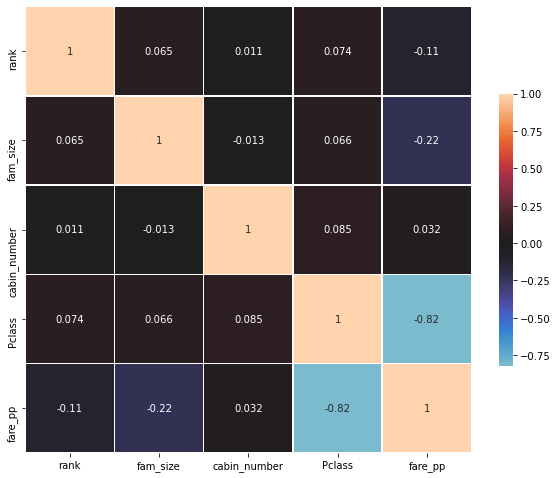

In [235]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.corr(), center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.savefig("titanic_corr.png", dpi=150, format="png")

In [236]:
# Split the DataFrame into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, train_size=0.65, test_size=0.35)

In [237]:
X_train.describe()

,rank,fam_size,cabin_number,Pclass,fare_pp
count,579.000000,579.000000,579.000000,579.000000,579.000000
mean,0.257340,0.095855,0.304865,0.671848,0.335376
std,0.238502,0.176618,0.121724,0.411031,0.145678
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.212329,0.500000,0.254097
50%,0.333333,0.000000,0.332192,1.000000,0.263620
75%,0.333333,0.100000,0.332192,1.000000,0.406274
max,1.000000,1.000000,0.863014,1.000000,1.000000


# Performing the Logistic Regression

In [241]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : (0.1, 1, 10, 100),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000]
    }
]

In [242]:
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
clf = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train,y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


/home/michael/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.62348877        nan 0.66666667 0.6701209
 0.6701209  0.68048359 0.6701209  0.6701209         nan        nan
        nan        nan        nan 0.75302245 0.75302245        nan
 0.75302245 0.75302245        nan        nan 0.62348877        nan
 0.66666667 0.6701209  0.6701209  0.68048359 0.6701209  0.6701209
        nan        nan        nan        nan        nan 0.75302245
 0.75302245        nan 0.75302245 0.75302245        nan        nan
 0.62348877        nan 0.66666667 0.6701209  0.6701209  0.68048359
 0.6701209  0.6701209         nan        nan        nan        nan
        nan 0.75302245 0.75302245        nan 0.75302245 0.75302245
        nan        nan 0.62348877        nan 0.66666667 0.6701209
 0.6701209  0.68048359 0.6701209  0.6701209         nan        nan
        nan        nan        nan 0.75302245 0.

In [240]:
best_clf.best_estimator_

LogisticRegression(C=4.281332398719396, solver='liblinear')

In [81]:
print (f'Accuracy - : {best_clf.score(X_test,y_test):.3f}')

Accuracy - : 0.785


In [243]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=10, random_state=42)
model.fit(X_train, y_train)
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))

train accuracy: 0.7547495682210709
test accuracy: 0.7467948717948718


# 3. Evaluate your model

## 3.1. Accuracy, Precision, Recall, F1, DummyClassifiers

In [83]:
from sklearn.metrics import accuracy_score
accuracy_score(model.predict(X_test), y_test)

0.7916666666666666

In [84]:
from sklearn.metrics import precision_score
precision_score(model.predict(X_test), y_test)

0.6209677419354839

In [85]:
from sklearn.metrics import recall_score
recall_score(model.predict(X_test), y_test)

0.8105263157894737

In [86]:
from sklearn.metrics import f1_score
f1_score(model.predict(X_test), y_test)

0.7031963470319634

In [87]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(model.predict(X_train), y_train)
accuracy_score(dummy_clf.predict(X_test), y_test)

0.6025641025641025

In [88]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(model.predict(X_train), y_train)
accuracy_score(dummy_clf.predict(X_test), y_test)

0.5512820512820513

In [89]:
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(model.predict(X_train), y_train)
accuracy_score(dummy_clf.predict(X_test), y_test)

0.4967948717948718

## 3.2. ROC-Curve

In [90]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = model.predict_proba(X_test)[:, 1]

In [91]:
ns_probs = [0 for y in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)

In [92]:
lr_auc = roc_auc_score(y_test, lr_probs)

In [93]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.830


In [94]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

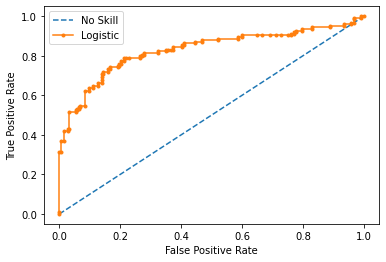

In [95]:
from matplotlib import pyplot
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## 3.3. Precision Recall Curve

In [96]:
from sklearn.metrics import precision_recall_curve
yhat = model.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[1])
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ValueError: Found input variables with inconsistent numbers of samples: [312, 2]

## 3.4. Decision Boundary
Plot the decision boundary for two scalar features from the Titanic dataset. Use this code example:

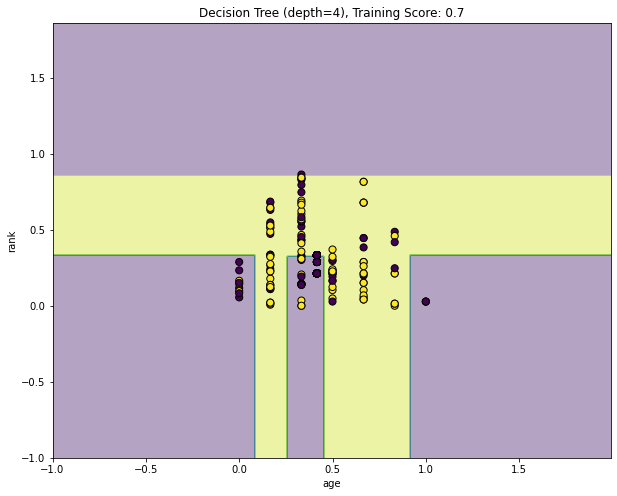

In [97]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

X2 = X_train.iloc[:,[0,3]].values
# Train a classification model
m = DecisionTreeClassifier(max_depth=4)
m.fit(X2, y_train)
# What about other models? Try them here as well.

#step size in the mesh
h = 0.01

# Plotting decision regions
#For that, we will assign a color to each point in the mesh [x_min, x_max] * [y_min, y_max]
x_min, x_max = X2[:][:, 0].min() - 1, X2[:][:, 0].max() + 1
y_min, y_max = X2[:][:, 1].min() - 1, X2[:][:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

Xgrid = np.c_[xx.ravel(), yy.ravel()]
Z = m.predict(Xgrid)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4)

#plot the training points
ax.scatter(X2[:, 0], X2[:, 1], c=y_train, s=50, edgecolor='k')
ax.set_title(f'Decision Tree (depth=4), Training Score: {round(m.score(X2, y_train), 2)}')
plt.xlabel('age')
plt.ylabel('rank')

plt.show()


# 5. Cross-validation Score

In [98]:
from sklearn.model_selection import cross_val_score
import statistics

model = LogisticRegression()
accuracy = cross_val_score(model, X_train, y_train, cv=15, scoring='accuracy')
print("cross-validation scores", accuracy)
print("median of cross-validation scores", statistics.median(accuracy))

cross-validation scores [0.66666667 0.76923077 0.8974359  0.74358974 0.8974359  0.74358974
 0.82051282 0.74358974 0.74358974 0.68421053 0.71052632 0.60526316
 0.73684211 0.86842105 0.78947368]
median of cross-validation scores 0.7435897435897436


# 6. Random Forest

## 6.1. Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion="entropy", n_estimators=1000, max_features='log2', max_depth=9, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [100]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[169,  19],
       [ 35,  89]])

## Random Forest Optimization

In [101]:
n_est = [500, 800, 1500, 2000]
max_feat = ["auto", "sqrt", "log2"]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
max_depth.append(None)
min_samples_split = [2, 3, 4, 10]
min_samples_leaf = [1, 2, 5, 10]

In [102]:
grid_param = {"n_estimators": n_est,
           "max_features": max_feat,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf  
           }

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
clf = RandomForestClassifier(random_state=42)
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=grid_param, n_iter=500, cv=2, verbose=2, random_state=42, n_jobs=-1)
clf_random.fit(X_train, y_train)
print(clf_random.best_params_)

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}


In [104]:
y_pred = clf_random.predict(X_test)
accuracy = clf_random.score(X_test, y_test)
print(accuracy)

0.8397435897435898


## 6.3. Ensemble Model

In [246]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

models = [('logreg', LogisticRegression(penalty='l2', C=1, max_iter=1000, random_state=42)),
          ("forest", RandomForestClassifier(criterion="entropy", n_estimators=2000, min_samples_split=10,
                                            min_samples_leaf=2, max_features="log2", max_depth=10,
                                            random_state=42)),
          ('svm', SVC(kernel='rbf', C=1, probability=True, random_state=42)),
          ]
m = VotingClassifier(models, n_jobs=-1, voting="hard")

m.fit(X_train, y_train)
ypreds = m.predict(X_test)
# m.score(X_test, y_test)

In [247]:
ypreds.transpose()

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [248]:
ypreds_df = pd.DataFrame(data=ypreds.transpose(), columns=["Survived"])

In [249]:
survivor_prediction_submission = pd.DataFrame(df_test["PassengerId"]).join(ypreds_df)

In [250]:
survivor_prediction_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [251]:
survivor_prediction_submission.to_csv("survivor_prediction_submission.csv", index=False)